# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [2]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp

# Function to add elements to a block so that it fits onto qubits
def complete(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 1000
        b11.append(vnew)
    return b11



In [3]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            bij = complete(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [4]:
import pandas as pd

pd.DataFrame(blocks['0,0'].to_matrix())

,0,1,2,3,4,5,6,7
0,2.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.00+0.00j,0.00+0.00j
1,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.00+0.00j,0.00+0.00j
2,0.0+0.0j,-1.0+0.0j,1.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.00+0.00j,0.00+0.00j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.00+0.00j,0.00+0.00j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,0.00+0.00j,0.00+0.00j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.00+0.00j,0.00+0.00j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,1000.0+0.0j,0.00+0.00j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.00+0.00j,1000.0+0.0j


In [5]:
print(blocks['0,0'])

SummedOp([
  250.75 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -249.75 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -249.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  250.0 * ZZI
])


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [6]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [7]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

def Ui_dagger(cir_i,phi_i):  
    
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q):
        cir_i.ry(-phi_i[q],q)
    
    return cir_i

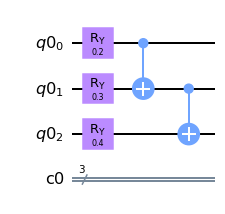

In [8]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

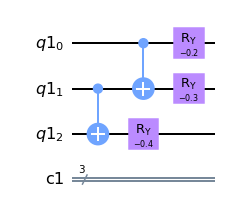

In [9]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)

tst_dagger = Ui_dagger(cir_i,[0.2,0.3,0.4])
tst_dagger.draw(output = 'mpl')

In [10]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

def U_dagger(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui_dagger(cir,phi_b[T-1-t])
    return cir

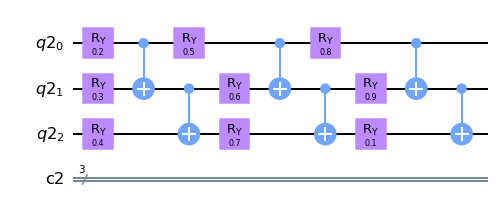

In [11]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

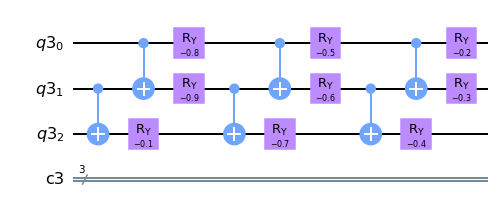

In [12]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U_dagger(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [13]:
#number of blocks
T = 1

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index

Now let us define a list of circuits whose projection onto $|000\ldots>$ are summed to get the value of $E$.  I will only do the upper blocks meaning that the wieght of the off diagonal blocks is doubled.

In [14]:
def E_Circs(phi,blocks):
    cir_l = []
    for key in list(blocks.keys()):
        for p in blocks[key]:
            qr = QuantumRegister(Q)
            cr = ClassicalRegister(Q)
            cir = QuantumCircuit(qr , cr)
            a = int(key.split(',')[0])
            b = int(key.split(',')[1])
            w = p.coeff
            if a != b:
                w = 2*p.coeff
            
            cir = U(cir,phi[b])
            p_cir = p.to_circuit()
            cir = cir.compose(p_cir)
            cir = U_dagger(cir,phi[a])
            cir.measure(qr, cr)
            
            cir_l.append([w,cir])
    
    return cir_l
            
        
        

-0.5


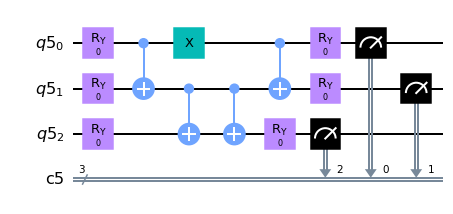

In [15]:
e_circs = E_Circs(phi,blocks)
p = 1
print(e_circs[p][0])
e_circs[p][1].draw(output = 'mpl')

## Simulate finding E

Before we move on to the optimization method, let's see how we can use *E_Circs* to find the value of E.  To do this I will use the qasm simulator from Aer.

In [16]:
from qiskit import Aer
from qiskit.visualization import *

In [17]:
#get the simulator
sim = Aer.get_backend("qasm_simulator")

To get a value for E, we execute each circuit, find the projection of the final circuit onto $|000\ldots>$, and multiply the result by the wieght of the circuit.

In [18]:
def find_E(e_circs):
    E = 0
    for p_circ in e_circs:
        circ = p_circ[1]
        w = p_circ[0]
        r = execute(circ, backend = sim).result().get_counts()
        r_keys = list(r.keys())
        total = 0
        for key in r_keys:
            total += r[key]
        if '000' in r:
            num = r['000']/total
        else:
            num = 0
        E += num*w

    #Normalize
    E = E/bL
    
    return E

In [19]:
find_E(e_circs)

-0.3333333333333333

For a sanity check, let's compare this to simple matrix multiplication

In [20]:
all_down = [0 for i in range(len(H))]
for b in range(bL):
    all_down[bL*b + 1] = 1/np.sqrt(bL)
    
np.dot(all_down,np.dot(H,all_down))

-0.3333333333333334

# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [21]:
import copy

In [96]:
def SPSA(k_max):
    #Initalization
    k = 0
    alpha = 0.602
    A = 10
    a = 0.002
    gamma = 0.101
    c = 0.02
    phi_k = np.array(phi)
    E_l = []
    
    #Being Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_Circs_A = E_Circs(phi_k + c_k*Delta_k ,blocks)
        E_Circs_B = E_Circs(phi_k - c_k*Delta_k ,blocks)
        E_A = find_E(E_Circs_A)
        E_B = find_E(E_Circs_B)
        
        #Calculate gradiant
        g = (E_A-E_B)/(2*c_k) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Calculate new E
        E_Circs_f = E_Circs(phi_k,blocks)
        E_f = find_E(E_Circs_f)
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
    return E_l

In [ ]:
El = SPSA(100)

k= 0 c_k= 0.02 a_k= 0.00047218436130948207 g= 27.461751302083332 E_A= 0.3184000651041667 E_B= -0.7800699869791666 E_f= -0.2927652994791667
k= 1 c_k= 0.01864772972873665 a_k= 0.00044808755848694924 g= -32.614961490026424 E_A= -0.9416097005208334 E_B= 0.2747802734375 E_f= -0.21036783854166666
k= 2 c_k= 0.017899493787135266 a_k= 0.00042700808451946097 g= -11.415147294264239 E_A= -0.048380533854166664 E_B= 0.3602701822916667 E_f= -0.2108154296875
k= 3 c_k= 0.017386891201800432 a_k= 0.0004083766650268662 g= -3.5092421347640648 E_A= 0.8076578776041666 E_B= 0.9296875 E_f= 0.15506998697916666
k= 4 c_k= 0.016999416915812672 a_k= 0.0003917626761548003 g= -1.1345747604471859 E_A= 0.5229899088541666 E_B= 0.5615641276041666 E_f= -0.16959635416666666
k= 5 c_k= 0.016689246121184963 a_k= 0.0003768337273895953 g= -32.85465950447527 E_A= -0.16817220052083334 E_B= 0.928466796875 E_f= -0.290771484375
k= 6 c_k= 0.016431419883627008 a_k= 0.00036332873351345896 g= 32.27067996578216 E_A= 1.3382568359375 E_B= 

In [ ]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [ ]:
pwd